In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split
#from networks import Model
#from dropout import *

from data import generate_data
#from train import train_main_model, train_deup
#from utils import inv_sigmoid, evaluate_and_plot, eval_error

import itertools

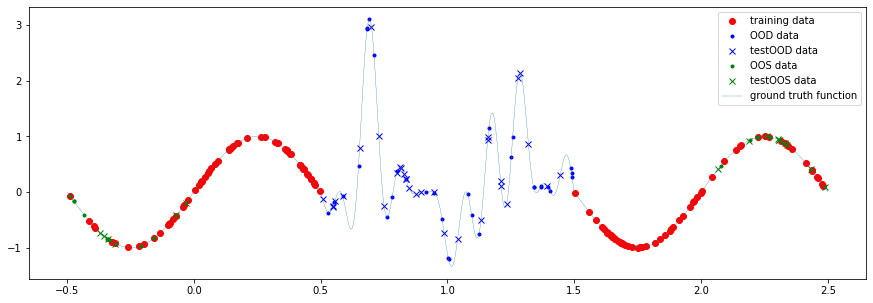

In [2]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 32, 64, seed=7, plot=True, device='cuda', shuffle=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [64]:
#main_net = nn.Sequential(nn.Linear(1, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256))

class main_net(nn.Module):
    def __init__(self, width=256):
        super().__init__()
        self.x_layer = nn.Linear(1, width)
        self.hidden_layer_1 = nn.Linear(width, width)
        self.hidden_layer_2 = nn.Linear(width, width)
    
    def forward(self, x, noise_1=None, noise_2=None):
        out = F.relu(self.x_layer(x))
        if noise_1 is not None:
            out = F.relu(self.hidden_layer_1(out)) * noise_1
        else:
            out = F.relu(self.hidden_layer_1(out))
        return self.hidden_layer_2(out) * noise_2 if noise_2 is not None else self.hidden_layer_2(out)

class noise_net(nn.Module):
    def __init__(self, noise_dim, width=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.noise_layer = nn.Linear(noise_dim, width, bias=True)
        self.x_layer = nn.Linear(1, width, bias=True)
        self.hidden_layer_1 = nn.Linear(width, width, bias=True)
        self.hidden_layer_2 = nn.Linear(width, width, bias=True)
        self.output_layer = nn.Linear(width, 256, bias=True)
    
    def forward(self, x, noise):
        out = F.relu(self.x_layer(x)) + self.noise_layer(noise) * (64 / self.noise_dim)
        out = F.relu(self.hidden_layer_1(out))
        #out = F.relu(self.noise_layer(noise))
        #out = F.relu(self.hidden_layer_1(out))
        #out = F.relu(self.hidden_layer_2(out))))
        out = F.relu(self.hidden_layer_2(out))
        return 1 + self.output_layer(out)

output_net = nn.Sequential(nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1))



In [23]:
#main_net = nn.Sequential(nn.Linear(1, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256))

class main_net(nn.Module):
    def __init__(self, width=256, noise_dim=64):
        super().__init__()
        self.x_layer = nn.Linear(16 + noise_dim, width)
        self.hidden_layer_1 = nn.Linear(width, width)
        self.hidden_layer_2 = nn.Linear(width, width)
    
    def forward(self, x, noise):
        out = F.relu(self.x_layer(torch.cat([x.repeat(1, 16), noise], dim=-1)))
        out = F.relu(self.hidden_layer_1(out))
        return self.hidden_layer_2(out)

class noise_net(nn.Module):
    def __init__(self, noise_dim, width=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.noise_layer = nn.Linear(noise_dim, width, bias=True)
        self.x_layer = nn.Linear(1, width, bias=True)
        self.hidden_layer_1 = nn.Linear(width, width, bias=True)
        self.hidden_layer_2 = nn.Linear(width, width, bias=True)
        self.output_layer = nn.Linear(width, 256, bias=True)
    
    def forward(self, x, noise):
        out = F.relu(self.x_layer(x)) + self.noise_layer(noise) * (64 / self.noise_dim)
        out = F.relu(self.hidden_layer_1(out))
        #out = F.relu(self.noise_layer(noise))
        #out = F.relu(self.hidden_layer_1(out))
        #out = F.relu(self.hidden_layer_2(out))))
        out = F.relu(self.hidden_layer_2(out))
        return 1 + self.output_layer(out)

output_net = nn.Sequential(nn.Linear(512, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1))



In [4]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(x, y)

#optimizer = torch.optim.Adam(itertools.chain(mu.parameters(), out.parameters()), lr=0.002)
#optimizer = torch.optim.Adam(itertools.chain(mu.parameters(),
#                                             out.parameters()), lr=0.002)
loss_fn = nn.MSELoss()
loss_fn_no_reduction = nn.MSELoss(reduction='none')


def train_mu(mu, sigma_1, sigma_2, out, optimizer, loss_fn, loader):
    gamma = 0.5
    losses = []
    for epoch in range(300):
        epoch_losses = []
        for batch_id, (xi, yi) in enumerate(loader):
            optimizer.zero_grad()

            # E_Z(F(x, Z)) == \mu(x)
            z = torch.randn(len(xi), noise_dim).cuda()
            #y_hat = out(mu(xi, sigma_1(xi, z), sigma_2(xi, z))) # * sigma(xi, z)
            y_hat = out(mu(xi, z)) # * sigma(xi, z)

            # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
            '''
            z_prime = torch.randn(len(xi) // 2, 10).cuda()
            xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
            yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
            mu_1 = out(mu(xi_1))
            mu_2 = out(mu(xi_2))
            r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime)) - mu_1
            r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
            r_1 = yi_1 - mu_1
            r_2 = yi_2 - mu_2
            '''
            f_loss = loss_fn(y_hat, yi) #+ gamma * loss_fn(r_hat_1*r_hat_2, r_1*r_2)
            epoch_losses.append(f_loss.item() * xi.shape[0])
            f_loss.backward()
            optimizer.step()
        losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
    return losses

In [66]:
k = 25
noise_bank = {}
noise_bank[16] = torch.randn(k, 16).cuda()
noise_bank[64] = torch.randn(k, 64).cuda()
noise_bank[256] = torch.randn(k, 256).cuda()

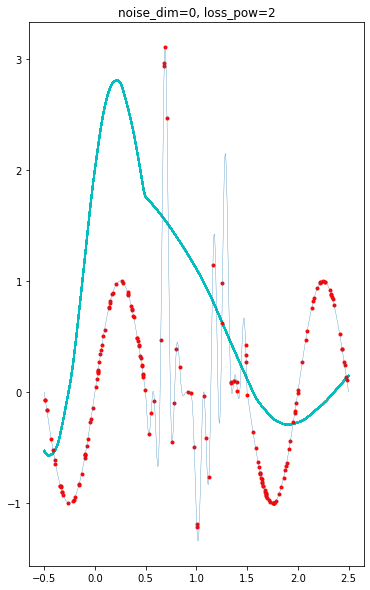

In [31]:
plt.figure(figsize=(6, 10))

plot_i = 1
for noise_dim in [0]: #[16, 64, 256]:
    for loss_pow in [2]: #, 2, 3]:
        
        plt.subplot(1, 1, plot_i)
        
        mu = main_net(noise_dim=noise_dim, width=512).cuda()
        #sigma = noise_net().cuda()
        #sigma_1 = noise_net(noise_dim=noise_dim, width=512).cuda()
        #sigma_2 = noise_net(noise_dim=noise_dim, width=512).cuda()
        out = output_net.cuda()
        
        optimizer = torch.optim.Adam(itertools.chain(mu.parameters(),
                                                     #sigma_1.parameters(),
                                                     #sigma_2.parameters(),
                                                     out.parameters()), lr=0.001)
        loader = DataLoader(train_data, shuffle=True, batch_size=64)

        #losses = train_mu(mu, sigma_1, sigma_2, out, optimizer, loss_fn, loader)
        
        #optimizer = torch.optim.Adam(itertools.chain(sigma_1.parameters(), sigma_2.parameters()), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x]), torch.cat([oos_y, ood_y, y]))
        deup_losses = []
        alpha = 2
        beta = 0
        gamma = 0.
        delta = 0.
        loader = DataLoader(oos_data, shuffle=True, batch_size=64)
        for epoch in range(200):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()
                
                xi_is_train = torch.Tensor([1 if i in x else 0 for i in xi]).bool().cuda()
                # E_Z(F(x, Z)) == \mu(x)
                z = torch.randn(len(xi[xi_is_train]), noise_dim).cuda()
                #z = noise_bank[noise_dim][torch.randint(0, k-1, (len(xi[xi_is_train]), )), :]
                #y_hat = out(mu(xi[xi_is_train], noise_1=sigma_1(xi[xi_is_train], z),
                #                   noise_2=sigma_2(xi[xi_is_train], z)))
                y_hat = out(F.relu(mu(xi[xi_is_train], z)))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                #z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_oos = xi[~xi_is_train]
                yi_oos = yi[~xi_is_train]
                xi_oos = xi_oos[:len(xi_oos)//2*2]
                yi_oos = yi_oos[:len(yi_oos)//2*2]
                xi_oos_1, xi_oos_2 = xi_oos[:len(xi_oos)//2], xi_oos[len(xi_oos)//2:]
                yi_oos_1, yi_oos_2 = yi_oos[:len(xi_oos)//2], yi_oos[len(xi_oos)//2:]
                z_prime = z[:len(xi_oos)//2, :]
                
                mu_1 = out(mu(xi_oos_1, torch.zeros_like(z_prime)))
                mu_2 = out(mu(xi_oos_2, torch.zeros_like(z_prime)))
                #r_hat_1 = out(mu(xi_oos_1, noise_1=sigma_1(xi_oos_1, z_prime),
                #                           noise_2=sigma_2(xi_oos_1, z_prime))) - mu_1
                #r_hat_2 = out(mu(xi_oos_2, noise_1=sigma_1(xi_oos_2, z_prime),
                #                           noise_2=sigma_2(xi_oos_2, z_prime))) - mu_2
                r_hat_1 = out(F.relu(mu(xi_oos_1, z_prime))) - mu_1
                r_hat_2 = out(F.relu(mu(xi_oos_2, z_prime))) - mu_2
                r_1 = yi_oos_1 - mu_1
                r_2 = yi_oos_2 - mu_2
                
                #z_prime_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                z_prime_prime = z[-len(xi_oos)//2:, :]
                
                #r_hat_hat_1 = out(mu(xi_oos_1, noise_1=sigma_1(xi_oos_1, z_prime_prime),
                #                               noise_2=sigma_2(xi_oos_1, z_prime_prime))) - mu_1
                #r_hat_hat_2 = out(mu(xi_oos_2, noise_1=sigma_1(xi_oos_2, z_prime_prime),
                #                               noise_2=sigma_2(xi_oos_2, z_prime_prime))) - mu_2
                r_hat_hat_1 = out(F.relu(mu(xi_oos_1, z_prime_prime))) - mu_1
                r_hat_hat_2 = out(F.relu(mu(xi_oos_2, z_prime_prime))) - mu_2
                #print(r_hat_1.shape, r_1.shape, r_hat_hat_1.shape, r_hat_hat_2.shape)
                f_loss = alpha * loss_fn(y_hat, yi[xi_is_train]) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow) + \
                         gamma * loss_fn((r_hat_1*r_hat_2), (r_1*r_2)) - \
                         delta * loss_fn(r_hat_1, r_hat_hat_1) - \
                         delta * loss_fn(r_hat_2, r_hat_hat_2)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
            scheduler.step()
            #print(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(100):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = out(mu(x_test, z)).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.plot(x_test.cpu(), y_test.squeeze().cpu(), label='ground truth function', linewidth=.3)
        plt.title(f'noise_dim={noise_dim}, loss_pow={loss_pow}')
        plot_i += 1

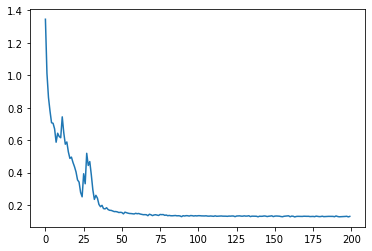

In [32]:
plt.plot(deup_losses)

In [ ]:
plt.figure(figsize=(30, 20))

plot_i = 1

loss_pow = 3
noise_dim = 64
batch_size = 32
gamma = 1
beta = 1

for width in [128, 256, 512]:
    for lr in [0.0005, 0.001, 0.002]:
        plt.subplot(3, 3, plot_i)
        
        sigma = noise_net(noise_dim=noise_dim, width=width).cuda()
        optimizer = torch.optim.Adam(itertools.chain(sigma.parameters()), lr=lr)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x[:256]]), torch.cat([oos_y, ood_y, y[:256]]))
        deup_losses = []
        loader = DataLoader(oos_data, shuffle=True, batch_size=batch_size)
        for epoch in range(150):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()

                # E_Z(F(x, Z)) == \mu(x)
                #z = torch.randn(len(xi), noise_dim).cuda()
                #y_hat = out(mu(xi) * sigma(xi, z))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
                yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
                mu_1 = out(mu(xi_1))
                mu_2 = out(mu(xi_2))
                r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime))  - mu_1
                r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
                r_1 = yi_1 - mu_1
                r_2 = yi_2 - mu_2

                #print(r_hat_1*r_hat_2, r_1*r_2)
                f_loss = gamma * loss_fn((r_hat_1*r_hat_2)**loss_pow, (r_1*r_2)**loss_pow) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(20):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = (out(mu(x_test)*sigma(x_test, z))).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.title(f'width={width}, lr={lr}')
        plot_i += 1

In [ ]:
plt.plot(losses, label='train losses')
plt.plot(deup_losses, label='deup losses')
#plt.plot(valid_losses, label='valid losses')
plt.legend()

In [ ]:
plt.figure(figsize=(15, 5))
non_dropout_pred = out(mu(x_test)).detach()

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

for _ in range(100):
    z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
    non_dropout_pred = (out(mu(x_test))*sigma(x_test, z)).detach()
    plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
non_dropout_pred = sigma(x_test, z).detach()

plt.plot(torch.cat([oos_x,ood_x]).cpu(), torch.cat([oos_y,ood_y]).cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()